In [52]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
def random_restart_environment(env):
    random_state = np.random.choice(range(env.observation_space.n))
    env.env.s = random_state
    return random_state

# suppress pandas warning
pd.options.mode.chained_assignment = None

# set seed
np.random.seed(42)

%matplotlib inline

In [53]:
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'k',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title='Frozen Lake'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    
#plot_lake(env, policy)

In [54]:
def get_score(env, policy, episodes=1000):
    misses = 0
    steps_list = []
    successes = 0  # Track the number of successful episodes
    for episode in range(episodes):
        observation = env.reset()
        steps = 0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps += 1
            if done and reward == 1:
                steps_list.append(steps)
                successes += 1  # Increment successful episodes count
                break
            elif done and reward == 0:
                misses += 1
                break
    
    if successes == 0:
        pct_fail = 100.0  # All episodes failed
        ave_steps = np.nan  # No successful episodes, set average steps to NaN
        std_steps = np.nan  # No successful episodes, set standard deviation to NaN
    else:
        pct_fail = (misses / successes) * 100
        ave_steps = np.mean(steps_list)
        std_steps = np.std(steps_list)
    
    print('----------------------------------------------')
    print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
    print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
    print('----------------------------------------------')
    
    return ave_steps, std_steps, pct_fail


In [55]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy 

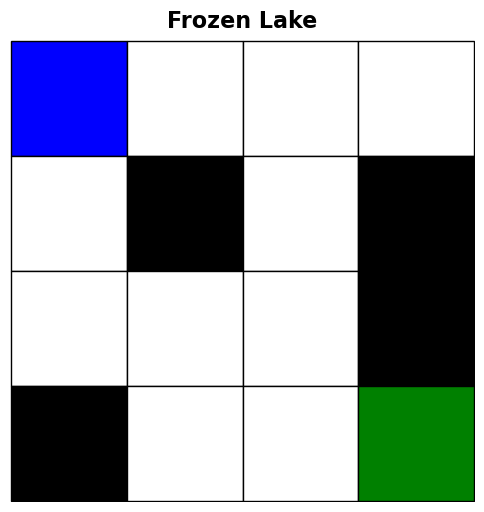

In [56]:
# Setup 4x4
env = gym.make('FrozenLake-v1').unwrapped

env.max_episode_steps=250
rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env)

In [57]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    t0 = time.time()
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            policy = policy.reshape(4,4)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = Time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = np.mean(mean_rewards) if mean_rewards else 0
            data['max_rewards'][testNum] = max(max_rewards) if max_rewards else 0
            data['error'][testNum] = max(errors) if errors else 0
            data['policy'][testNum] = ','.join(map(str, list(test.policy)))
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, Time, iters, maxR))
            
            if showResults:
                title = 'FrozenLake_VI_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_e' + str(e)
                plot_lake(env, policy, title)
            
            testNum = testNum + 1
                
    endTime = time.time() - t0
    print("Time taken: %.2f" %endTime)
    
    # See differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [58]:
gammas   = [0.1, 0.3, 0.6, 0.9]
epsilons = [1e-2, 1e-5, 1e-8, 1e-12]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

interest = ['gamma', 'epsilon', 'time', 'iterations', 'reward']
df = vi_data[interest]
#vi_data.head()

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.10,	1E-02,	0.00,	1,	0.333333
0.10,	1E-05,	0.00,	4,	0.345235
0.10,	1E-08,	0.00,	7,	0.345239
0.10,	1E-12,	0.00,	11,	0.345239
0.30,	1E-02,	0.00,	3,	0.373333
0.30,	1E-05,	0.00,	8,	0.375101
0.30,	1E-08,	0.00,	13,	0.375103
0.30,	1E-12,	0.00,	20,	0.375103
0.60,	1E-02,	0.00,	6,	0.445120
0.60,	1E-05,	0.00,	17,	0.447647
0.60,	1E-08,	0.00,	29,	0.447649
0.60,	1E-12,	0.00,	46,	0.447649
0.90,	1E-02,	0.00,	26,	0.637540
0.90,	1E-05,	0.00,	77,	0.639019
0.90,	1E-08,	0.00,	128,	0.639020
0.90,	1E-12,	0.01,	195,	0.639020
Time taken: 0.06
----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
----------------------------------------------
----------------------------------------------
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
------------------------

/var/folders/jt/7yzgm5mx5pvbbndt900r1s0m0000gn/T/ipykernel_25377/583246607.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data['policy'][testNum] = ','.join(map(str, list(test.policy)))


In [59]:
csv_file_path = "results-frozenlake.csv"

In [60]:
df.to_csv(csv_file_path, index=False)